[*********************100%%**********************]  2 of 2 completed


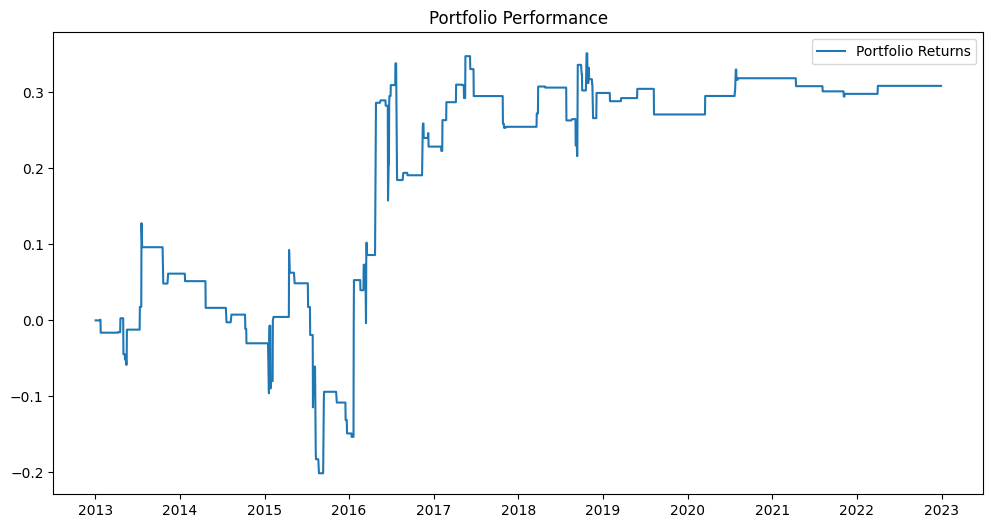

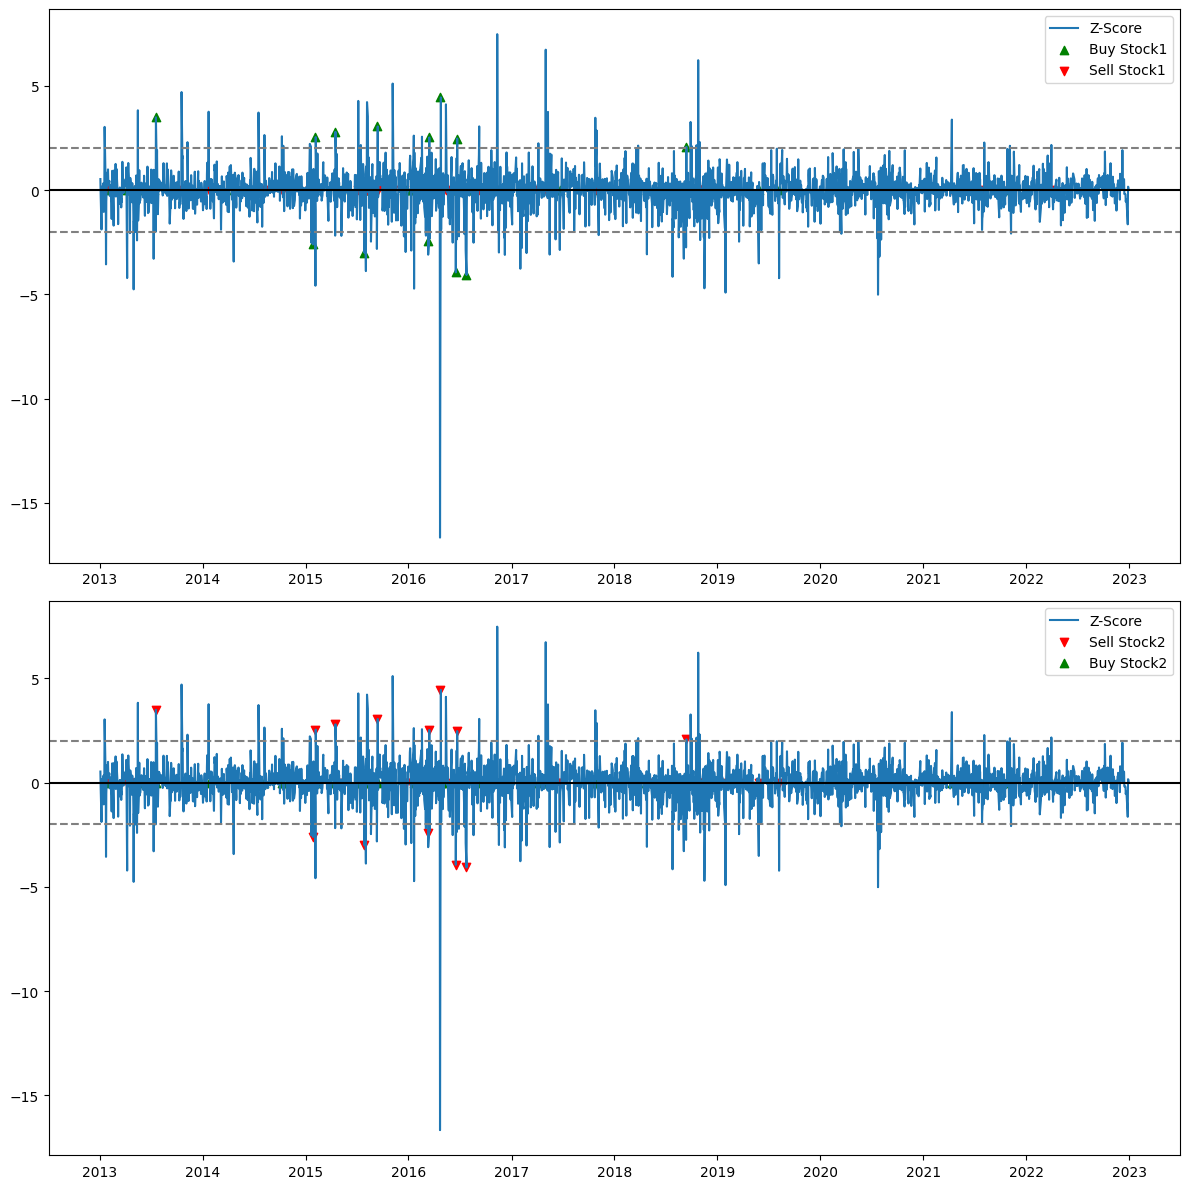

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def pairs_trading_backtest(stock1, stock2, start, end, entry_threshold=2.0, exit_threshold=0):
    data = yf.download([stock1, stock2], start=start, end=end)['Adj Close']
    returns = data.pct_change().dropna()
    spread = returns[stock1] - returns[stock2]
    z_score = (spread - spread.mean()) / spread.std()

    portfolio = pd.Series(index=data.index, dtype=float).fillna(0.0)
    traded_entries = pd.Series(index=data.index, dtype=float).fillna(0.0)
    traded_exits = pd.Series(index=data.index, dtype=float).fillna(0.0)
    positions = pd.DataFrame(index=data.index, dtype=float).fillna(0.0)

    for i in range(1, len(data) - 1):
        z = z_score[i]
        if z < -entry_threshold:
            positions.loc[data.index[i+1], stock1] = 1
            positions.loc[data.index[i+1], stock2] = -1
            traded_entries[i] = z_score[i]
        elif z > entry_threshold:
            positions.loc[data.index[i+1], stock1] = -1
            positions.loc[data.index[i+1], stock2] = 1
            traded_entries[i] = z_score[i]
        elif abs(z) <= exit_threshold:
            positions.loc[data.index[i+1], stock1] = 0
            positions.loc[data.index[i+1], stock2] = 0
            traded_exits[i] = z_score[i]

        portfolio.iloc[i+1] = (positions.iloc[i] * returns.iloc[i]).sum()

    portfolio = portfolio.cumsum()

    plt.figure(figsize=(12, 6))
    plt.title('Portfolio Performance')
    plt.plot(portfolio, label='Portfolio Returns')
    plt.legend()
    plt.show()

    fig, axes = plt.subplots(2, 1, figsize=(12, 12))

    # For stock1
    axes[0].plot(z_score, label="Z-Score")
    axes[0].scatter(traded_entries.where(positions[stock1] == 1).dropna().index,
                   traded_entries.where(positions[stock1] == 1).dropna(),
                   marker='^', color='g', label='Buy Stock1', alpha=1)
    axes[0].scatter(traded_exits.where(positions[stock1] == -1).dropna().index,
                   traded_exits.where(positions[stock1] == -1).dropna(),
                   marker='v', color='r', label='Sell Stock1', alpha=1)

    # For stock2
    axes[1].plot(z_score, label="Z-Score")
    axes[1].scatter(traded_entries.where(positions[stock2] == -1).dropna().index,
                   traded_entries.where(positions[stock2] == -1).dropna(),
                   marker='v', color='r', label='Sell Stock2', alpha=1)
    axes[1].scatter(traded_exits.where(positions[stock2] == 1).dropna().index,
                   traded_exits.where(positions[stock2] == 1).dropna(),
                   marker='^', color='g', label='Buy Stock2', alpha=1)

    # Add other common elements
    for ax in axes:
        ax.axhline(entry_threshold, color='grey', linestyle='--')
        ax.axhline(-entry_threshold, color='grey', linestyle='--')
        ax.axhline(0, color='black', linestyle='-')
        ax.legend()

    plt.tight_layout()
    plt.show()

pairs_trading_backtest('NVDA', 'AMD', '2013-01-01', '2023-01-01')